In [1]:
#imports and installations
import pandas as pd
from sklearn.model_selection import train_test_split #for splitting the data
from sklearn.preprocessing import StandardScaler #for standardisation
from sklearn.linear_model import LogisticRegression #for baseline model
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score #for metrics
# pip install xgboost lightgbm
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
!pip uninstall xgboost -y
!pip install xgboost

# from xgboost import XGBClassifier


import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import os

Found existing installation: xgboost 3.0.2
Uninstalling xgboost-3.0.2:
  Successfully uninstalled xgboost-3.0.2
  Using cached xgboost-3.0.2-py3-none-macosx_12_0_arm64.whl.metadata (2.1 kB)
Using cached xgboost-3.0.2-py3-none-macosx_12_0_arm64.whl (2.0 MB)

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
#Importing data
X = pd.read_csv("X.csv") 
y = pd.read_csv("y.csv")

In [3]:
#train_test split, Split X and y into train/test

#Splitting X and y into train and test sets(80/20), while preserving the class imbalance(ratio of returned, non-retuned) 
#with stratify as class is imbalanced

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [4]:
X.dtypes

delivery_delay                     float64
payment_value                      float64
price                              float64
customer_state_SP                     bool
product_category_bed_bath_table       bool
review_score                       float64
dtype: object

In [5]:
#we are converting boolean to int as its friendly for future pipeline building

X_train[['customer_state_SP','product_category_bed_bath_table']] = X_train[['customer_state_SP','product_category_bed_bath_table']].astype(int)
X_test[['customer_state_SP','product_category_bed_bath_table']] = X_test[['customer_state_SP','product_category_bed_bath_table']].astype(int)

In [6]:
#Standardising numerical columns
num_cols = ['delivery_delay', 'payment_value', 'price', 'review_score']

# Fit and transform on train, transform on test
scaler= StandardScaler()
X_train[num_cols]=scaler.fit_transform(X_train[num_cols])
X_test[num_cols]=scaler.transform(X_test[num_cols])

In [7]:
X_train.to_csv("/Users/lakshmiprasannapoluru/Desktop/smart-return-predictor/data/X_train.csv", index=False)
X_test.to_csv("/Users/lakshmiprasannapoluru/Desktop/smart-return-predictor/data/X_test.csv", index=False)

y_train.to_csv("/Users/lakshmiprasannapoluru/Desktop/smart-return-predictor/data/y_train.csv", index=False)
y_test.to_csv("/Users/lakshmiprasannapoluru/Desktop/smart-return-predictor/data/y_test.csv", index=False)

In [8]:
#Train Baseline Model

params={'class_weight':'balanced', 'max_iter':1000, 'random_state':42}

lr= LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr.fit(X_train, y_train)
y_pred= lr.predict(X_test)
y_prob = lr.predict_proba(X_test)[:, 1]

/Users/lakshmiprasannapoluru/Desktop/smart-return-predictor/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [9]:
# Evaluate the model

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))

[[20450  2569]
 [   12    96]]
              precision    recall  f1-score   support

           0       1.00      0.89      0.94     23019
           1       0.04      0.89      0.07       108

    accuracy                           0.89     23127
   macro avg       0.52      0.89      0.50     23127
weighted avg       0.99      0.89      0.94     23127

ROC AUC Score: 0.9277923390178484


In [10]:
#Tune the classification threshold (Right now, predict() uses default threshold = 0.5
# But maybe predicting return only if probability > 0.9 improves precision.)
# Set threshold high (e.g., 0.85 to 0.95)
threshold = 0.9
y_pred_thresh = (y_prob > threshold).astype(int)

In [11]:
# Re-evaluate
print(confusion_matrix(y_test, y_pred_thresh))
print(classification_report(y_test, y_pred_thresh))

[[22047   972]
 [   61    47]]
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     23019
           1       0.05      0.44      0.08       108

    accuracy                           0.96     23127
   macro avg       0.52      0.70      0.53     23127
weighted avg       0.99      0.96      0.97     23127



In [12]:
#trying to find the best threshold to tune

threshold=[0,0.5,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1.0]
for num in threshold:
    y_pred_thresh = (y_prob > num).astype(int)
    # Re-evaluate
    print('I am for this ', num )
    print(confusion_matrix(y_test, y_pred_thresh))
    print(classification_report(y_test, y_pred_thresh))

/Users/lakshmiprasannapoluru/Desktop/smart-return-predictor/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/lakshmiprasannapoluru/Desktop/smart-return-predictor/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/lakshmiprasannapoluru/Desktop/smart-return-predictor/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zer

I am for this  0
[[    0 23019]
 [    0   108]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     23019
           1       0.00      1.00      0.01       108

    accuracy                           0.00     23127
   macro avg       0.00      0.50      0.00     23127
weighted avg       0.00      0.00      0.00     23127

I am for this  0.5
[[20450  2569]
 [   12    96]]
              precision    recall  f1-score   support

           0       1.00      0.89      0.94     23019
           1       0.04      0.89      0.07       108

    accuracy                           0.89     23127
   macro avg       0.52      0.89      0.50     23127
weighted avg       0.99      0.89      0.94     23127

I am for this  0.1
[[13430  9589]
 [    2   106]]
              precision    recall  f1-score   support

           0       1.00      0.58      0.74     23019
           1       0.01      0.98      0.02       108

    accuracy                      

/Users/lakshmiprasannapoluru/Desktop/smart-return-predictor/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/lakshmiprasannapoluru/Desktop/smart-return-predictor/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/lakshmiprasannapoluru/Desktop/smart-return-predictor/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zer

In [13]:
threshold = 0.65
y_pred_final = (y_prob > threshold).astype(int)

In [14]:
#Extracting final metrics

precision = precision_score(y_test, y_pred_final)
recall = recall_score(y_test, y_pred_final)
f1 = f1_score(y_test, y_pred_final)
roc_auc_lr = roc_auc_score(y_test, y_prob)

report_lr =classification_report(y_test, y_pred_final, output_dict=True)

print('precision :',precision,'\n','recall :',recall,'\n','f1_score :',f1,'\n','roc-auc:',roc_auc_lr,'\n')

precision : 0.046875 
 recall : 0.8611111111111112 
 f1_score : 0.08891013384321224 
 roc-auc: 0.9277923390178484 



In [15]:
print(report_lr)

{'0': {'precision': 0.9992905453341532, 'recall': 0.9178504713497545, 'f1-score': 0.9568407227933518, 'support': 23019.0}, '1': {'precision': 0.046875, 'recall': 0.8611111111111112, 'f1-score': 0.08891013384321224, 'support': 108.0}, 'accuracy': 0.9175855061183897, 'macro avg': {'precision': 0.5230827726670766, 'recall': 0.8894807912304328, 'f1-score': 0.522875428318282, 'support': 23127.0}, 'weighted avg': {'precision': 0.9948428919897467, 'recall': 0.9175855061183897, 'f1-score': 0.9527876029072181, 'support': 23127.0}}


In [16]:
import mlflow

In [17]:
mlflow.set_tracking_uri('http://127.0.0.1:5000')
mlflow.set_experiment('smart_return_predictor_v1')

with mlflow.start_run(run_name='lr_return_classifier'):
    mlflow.log_params(params)
    mlflow.log_metrics({ "accuracy":report_lr['accuracy'],
            "precision_class_0": report_lr['0']['precision'],
            "precision_class_1": report_lr['1']['precision'],
            "recall_class_0": report_lr['0']['recall'],
            "recall_class_1": report_lr['1']['recall'],
            "f1_score_macro": report_lr['macro avg']['f1-score'],
            "roc_auc_lr": roc_auc_lr})

    mlflow.sklearn.log_model(lr,"Logistic Regression")

2025/07/10 19:13:30 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/10 19:13:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run lr_return_classifier at: http://127.0.0.1:5000/#/experiments/556244038881834029/runs/c96a76c6b72e4ccdb847bcc55e9d3b0e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/556244038881834029


In [18]:
#Trying RF, XGBoost, LGB models

models = {
    "RandomForest": RandomForestClassifier(class_weight='balanced', random_state=42),
    "XGBoost": xgb.XGBClassifier(scale_pos_weight=100, use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": lgb.LGBMClassifier(scale_pos_weight=100, random_state=42)
}

trained_models={}
threshold = 0.65

#Added scale_pos_weight as classes are highly imbalanced

for name, model in models.items():
    print(f"\n Training {name}")
    model.fit(X_train, y_train)
    
    y_prob = model.predict_proba(X_test)[:, 1]
    y_pred = (y_prob > threshold).astype(int)

    cm=confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    roc_auc = roc_auc_score(y_test, y_prob)


    print(f"\n Results for {name} at threshold = {threshold}")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print("ROC AUC Score:", roc_auc_score(y_test, y_prob))

    trained_models[name]={
        "model" : model,
        "report": report,
        "roc_auc": roc_auc,
        "cm" : cm        
    }

/Users/lakshmiprasannapoluru/Desktop/smart-return-predictor/venv/lib/python3.12/site-packages/sklearn/base.py:1363: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



 Training RandomForest

 Results for RandomForest at threshold = 0.65
[[23013     6]
 [   86    22]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23019
           1       0.79      0.20      0.32       108

    accuracy                           1.00     23127
   macro avg       0.89      0.60      0.66     23127
weighted avg       1.00      1.00      0.99     23127

ROC AUC Score: 0.9342469505867135

 Training XGBoost


/Users/lakshmiprasannapoluru/Desktop/smart-return-predictor/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:13:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 Results for XGBoost at threshold = 0.65
[[22843   176]
 [   32    76]]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     23019
           1       0.30      0.70      0.42       108

    accuracy                           0.99     23127
   macro avg       0.65      0.85      0.71     23127
weighted avg       1.00      0.99      0.99     23127

ROC AUC Score: 0.9909507122135819

 Training LightGBM
[LightGBM] [Info] Number of positive: 430, number of negative: 92076
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000940 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 663
[LightGBM] [Info] Number of data points in the train set: 92506, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004648 -> initscore=-5.366584
[LightGBM] [Info] Start training from score -5

/Users/lakshmiprasannapoluru/Desktop/smart-return-predictor/venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/lakshmiprasannapoluru/Desktop/smart-return-predictor/venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no 

In [19]:
# print(trained_models)

2025/07/10 19:13:39 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/10 19:13:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/07/10 19:13:42 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Logged RandomForest model and metrics to MLflow
🏃 View run RandomForest_return_classifier at: http://127.0.0.1:5000/#/experiments/556244038881834029/runs/8e9eb22e270d486a98949e18be94666e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/556244038881834029


2025/07/10 19:13:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logged XGBoost model and metrics to MLflow
🏃 View run XGBoost_return_classifier at: http://127.0.0.1:5000/#/experiments/556244038881834029/runs/a6e7acc32aa84db8a283a8e9c3b08242
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/556244038881834029


2025/07/10 19:13:46 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/10 19:29:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logged LightGBM model and metrics to MLflow
🏃 View run LightGBM_return_classifier at: http://127.0.0.1:5000/#/experiments/556244038881834029/runs/f42d30f7a8b84db1ba27e56d4f92ef03
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/556244038881834029


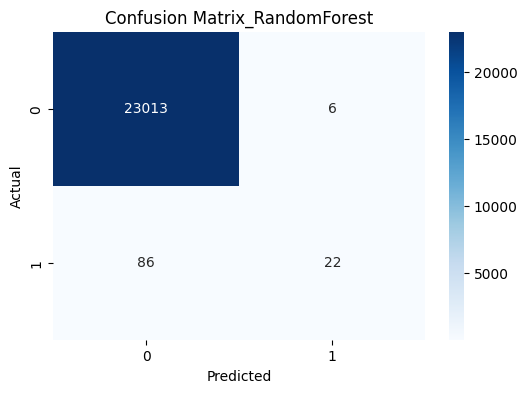

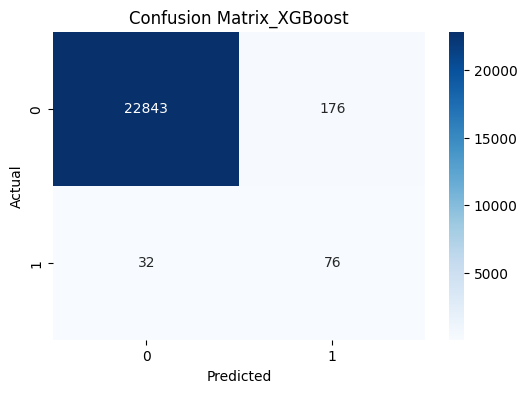

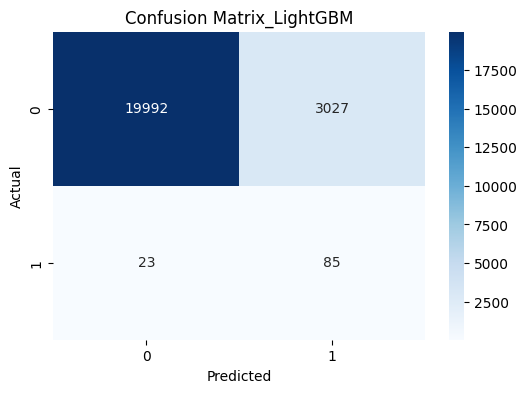

In [20]:
#MLFlow logginfg for RF, XGBoost, LGB Models 

mlflow.set_tracking_uri('http://127.0.0.1:5000')
mlflow.set_experiment('smart_return_predictor_v1')

for name, data in trained_models.items():
    model=data['model']
    report=data['report']
    roc_auc=data['roc_auc']
    cm=data['cm']
    
    with mlflow.start_run(run_name=f"{name}_return_classifier"):
        mlflow.log_param("threshold", threshold)
        mlflow.log_params(model.get_params())

        mlflow.log_metrics({
            "accuracy": report['accuracy'],
            "precision_class_0": report['0']['precision'],
            "precision_class_1": report['1']['precision'],
            "recall_class_0": report['0']['recall'],
            "recall_class_1": report['1']['recall'],
            "f1_score_macro": report['macro avg']['f1-score'],
            "roc_auc": roc_auc
        })

        # Confusion Matrix plot
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f"Confusion Matrix_{name}")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
    
        # Save confusion matrix
        os.makedirs("outputs", exist_ok=True)
        plt.savefig(f"outputs/confusion_matrix_{name}.png")
        mlflow.log_artifact(f"outputs/confusion_matrix_{name}.png")

        mlflow.sklearn.log_model(model,f"{name}_model")

        print(f"Logged {name} model and metrics to MLflow")